# Introduction

This notebook is part of the bachelor's thesis Solving the 3-SAT problem using quantum algorithms done by Arnau Casau at FIB - UPC Universitat Politècnica de Catalunya.

This code is a continuation of the previous notebook called *Part-1-3SAT-Quantum-Computing.ipynb*, in which we can find an implementation of Grover's algorithm to solve instances of the 3-SAT problem. The previous algorithm allows us to achieve a quadratic speedup over a random guessing classical algorithm.

In the following paragraphs, we will see that there are classical algorithms that can improve what we've got with Grover's and what we can do with a quantum computer to obtain an even better algorithm than the classical ones.

# Schöning's algorithm

Schöning's algorithm is a classical algorithm that allows us to find satisfiable assignments to 3-SAT instances. This algorithm is quite simple, and here we can see what it looks like:

```
input: a formula in k-CNF whit n variables
Guess and initial assignment x ∈ {0,1}^n
Repeat 3n times:
    If the formula is satisfied by the actual assignment:
        Stop and accept
    Let C be some clause not being satisfied by the actual assignment
    Pick one of the <= k literals in the clause at random and flip its value in the current assignment
```
This algorithm is polynomial to the number of variables in our formula, and it has a probability of success of at least $(2-{2\over{k}})^{-n}$. In this case, because we are trying to solve 3-SAT, we have a probability of $({4\over{3}})^{-n}$. To find a satisfiable assignment with high probability, we will have to repeat the algorithm ${1\over{({4\over{3}})^{-n}}}=({4\over{3}})^{n}$ times. If we do so, we see that the time complexity after the repetitions is $O(({4\over{3}})^{n}\cdot poly(n))$, which is better than the one achieved with Grover's.

# Amplitude Amplification and Schöning's algorithm

Even though Schöning's algorithm is better than Grover's algorithm of the previous notebook, we still can do something about it. If we create a circuit that carries out the bit-toggling part of Schöning's algorithm, we can use this as the oracle of Grover's algorithm (generalized as Amplitude Amplification) and achieve a quadratic speedup over the number of repetitions that we should have done with classical Schöning's algorithm. This leads us to a time complexity of $O(\sqrt{({4\over{3}})^{n}}\cdot poly(n))$.

Schöning's algorithm is a random walk, but we can create a circuit, in which we view the 3n step as a deterministic algorithm with an additional input r ∈ {0,1}$^n$ x {1,2,3}$^{3n}$, where the first n bits determine x, and the last 3n entries determine which variable of the leftmost false clauses will be flipped in the 3n steps of the random walk (In the algorithm proposed below, we will always use the first unsatisfied clause to simplify the circuit). Finally, we will use the Amplitude Amplification on the space of all such r.

Here we can find a table with all the algorithm that I've mentioned above and their time complexity:


| Algorithm  | Type | Time complexity |
| -------------: |:--:| :------------- |
| Random guessing | Classical | $O(2^n)$  |
| Grover search |Quantum | $O(1.4142^n)$  |
| Schöning | Classical| $O(1.3334^n)$  |
| Amplitude Amplification/Schöning |Quantum/Classical | $O(1.1547^n)$  |


In [1]:
# imports
import math

# importing Qiskit
from qiskit import QuantumCircuit, Aer, assemble, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

Like in the previous notebook, we can read the formula from a text file. The only difference, in this case, is the number of total qubits we need to create the circuit. We need n qubits to represent all the possible assignments, where n is the number of variables in the formula.

We also need, for each of the 3n iterations, one qubit for clause and two qubits more that we will use to represent the random choice the algorithm does when it flips the value of one variable in the leftmost false clause. Finally, we will need as many qubits as clauses to determine if an assignment satisfies the formula after the 3n steps of Schöning's part and one extra qubit to represent the state |-⟩ to perform a phase shift of -1 to all solutions in the oracle.

This expression summarizes all that has been said above, where n is the number of variables in the formula and c is the number of clauses thereof:

Number of qubits: $n + 3n \cdot(2 + c) + c + 1$

In [2]:
f = open("cnf_test2.txt")
info = f.readline().split(' ')
n_var = int(info[0])
n_clause = int(info[1])

lines = [line.rstrip('\n') for line in f]

formula = []
for i in lines:
    l = i.split(' ')
    formula.append([int(l[0]),int(l[1]),int(l[2])])

n_qubits = n_var + 3*n_var*(2 + n_clause) + n_clause + 1
n_measures = 7*n_var
iters = 3*n_var

The first step of the Amplitude Amplification is to initialize all the qubits. As we have seen above, the state space of the algorithm will be all the inputs r ∈ {0,1}$^n$ x {1,2,3}$^{3n}$. To create this state is easy to see that the first n qubits have to be in a superposition because we want to represent all the possible assignments of our formula. To achieve that, we only have to use a Hadamard gate in those qubits as we have done in the previous notebook.

To represent the choice of one literal in each of the 3n steps in Schöning's algorithm, we can create 3n times the state $1\over{\sqrt{3}}$ $(|00⟩ + |01⟩ + |10⟩)$, which is a superposition state and will collapse with equal probability in the states |00⟩, |01⟩ o |10⟩. We can use the decimal representation of these states to decide which literal in the chosen false clause will be modified.

In order to build the state $1\over{\sqrt{3}}$ $(|00⟩ + |01⟩ + |10⟩)$ we will use 2 qubits initialized to |00⟩ and two gates. The first gate we need is Ry($\theta$), which will perform a rotation of $\theta$ degrees around the y-axis. The second one we need is the Hadamard gate but his controlled version, as we will see as follows.

The angle $\theta$ we will need to create the state is $\theta = 2 \cdot arccos \cdot (\sqrt{2\over3})$.

|00⟩ -> Perform the Ry($\theta$) gate on the first qubit -> $(\sqrt{{2\over3}}|0⟩ + \sqrt{{1\over3}}|1⟩) |0⟩ = \sqrt{{2\over3}}|00⟩ + \sqrt{{1\over3}}|10⟩$ -> Use the Hadamard gate on the second qubit when the first one is 0 -> $\sqrt{{2\over3}}|0⟩ (\sqrt{{1\over2}}|0⟩ + \sqrt{{1\over2}}|1⟩) + \sqrt{{1\over3}}|10⟩ = \sqrt{{1\over3}}|00⟩ + \sqrt{{1\over3}}|01⟩ + \sqrt{{1\over3}}|10⟩ = {1\over{\sqrt{3}}} (|00⟩ + |01⟩ + |10⟩)$

To better understand why the angle $\theta$ has the value said above, we need to remember the matrix that represents the gate:

$$
Ry(\theta) = \left(\begin{array}{cc} 
cos({\theta\over{2}}) & -sin({\theta\over{2}})\\
sin({\theta\over{2}}) & cos({\theta\over{2}})
\end{array}\right)
$$

In the following piece of code, we can find the initialization of all qubits doing the above said. The last qubit is initialized to the state |-⟩ using a NOT gate and a Hadamard gate, as we have seen in the previous notebook.

The circuit is encapsulated into a gate called *Initialization* that we will use later.

In [3]:
qc = QuantumCircuit(n_qubits)

for i in range(n_var):
    qc.h(i)

ini = n_var+n_clause
theta = 2*math.acos(math.sqrt(2/3))
for i in range(iters):
    qc.u(theta,0,0,ini)
    qc.x(ini)
    qc.ch(ini, ini+1)
    qc.x(ini)
    ini += 2+n_clause

qc.x(n_qubits-1)
qc.h(n_qubits-1)

initial = qc.to_gate()
initial.name = "Initialization"
qc.draw()

┌───┐                     
 q_0: ─────┤ H ├─────────────────────
           ├───┤                     
 q_1: ─────┤ H ├─────────────────────
           ├───┤                     
 q_2: ─────┤ H ├─────────────────────
           └───┘                     
 q_3: ───────────────────────────────
                                     
 q_4: ───────────────────────────────
                                     
 q_5: ───────────────────────────────
                                     
 q_6: ───────────────────────────────
                                     
 q_7: ───────────────────────────────
                                     
 q_8: ───────────────────────────────
                                     
 q_9: ───────────────────────────────
      ┌──────────────┐┌───┐     ┌───┐
q_10: ┤ U(1.231,0,0) ├┤ X ├──■──┤ X ├
      └──────────────┘└───┘┌─┴─┐└───┘
q_11: ─────────────────────┤ H ├─────
                           └───┘     
q_12: ───────────────────────────────
                                     
q_13: ───────────────────────────────
                                     
q_14: ───────────────────────────────
                                     
q_15: ───────────────────────────────
                                     
q_16: ───────────────────────────────
                                     
q_17: ───────────────────────────────
                                     
q_18: ───────────────────────────────
      ┌──────────────┐┌───┐     ┌───┐
q_19: ┤ U(1.231,0,0) ├┤ X ├──■──┤ X ├
      └──────────────┘└───┘┌─┴─┐└───┘
q_20: ─────────────────────┤ H ├─────
                           └───┘     
q_21: ───────────────────────────────
                                     
q_22: ───────────────────────────────
                                     
q_23: ───────────────────────────────
                                     
q_24: ───────────────────────────────
                                     
q_25: ───────────────────────────────
                                     
q_26: ───────────────────────────────
                                     
q_27: ───────────────────────────────
      ┌──────────────┐┌───┐     ┌───┐
q_28: ┤ U(1.231,0,0) ├┤ X ├──■──┤ X ├
      └──────────────┘└───┘┌─┴─┐└───┘
q_29: ─────────────────────┤ H ├─────
                           └───┘     
q_30: ───────────────────────────────
                                     
q_31: ───────────────────────────────
                                     
q_32: ───────────────────────────────
                                     
q_33: ───────────────────────────────
                                     
q_34: ───────────────────────────────
                                     
q_35: ───────────────────────────────
                                     
q_36: ───────────────────────────────
      ┌──────────────┐┌───┐     ┌───┐
q_37: ┤ U(1.231,0,0) ├┤ X ├──■──┤ X ├
      └──────────────┘└───┘┌─┴─┐└───┘
q_38: ─────────────────────┤ H ├─────
                           └───┘     
q_39: ───────────────────────────────
                                     
q_40: ───────────────────────────────
                                     
q_41: ───────────────────────────────
                                     
q_42: ───────────────────────────────
                                     
q_43: ───────────────────────────────
                                     
q_44: ───────────────────────────────
                                     
q_45: ───────────────────────────────
      ┌──────────────┐┌───┐     ┌───┐
q_46: ┤ U(1.231,0,0) ├┤ X ├──■──┤ X ├
      └──────────────┘└───┘┌─┴─┐└───┘
q_47: ─────────────────────┤ H ├─────
                           └───┘     
q_48: ───────────────────────────────
                                     
q_49: ───────────────────────────────
                                     
q_50: ───────────────────────────────
                                     
q_51: ───────────────────────────────
                                     
q_52: ───────────────

The next step in the Amplitude Amplification is to design the oracle to mark the solutions of our formula, but this is a large circuit because we have to simulate the 3n iterations of Schöning's algorithm. To better understand all the parts, we can take as an example only the first iteration of Schöning's in a small formula of four variables and two clauses:

(-x1 v -x2 v x3) ∧ (x2 v x3 v -x4)

I have also depicted the circuit in LaTeX with the package *quantikz* to explain the three main steps and to help the reader to visualize it. The three phases are:

* (Green) The initialization of all qubits we have done above.
* (Orange) Check the clauses to determine which one has been satisfied by the actual assignment using auxiliary qubits.
* (Red) Flip one out of three literals of the leftmost unsatisfied clause.

As we can see in the orange step, to determine whether a clause has been satisfied, we can do the same as in the previous notebook. We can use a Toffoli gate with the qubits representing the negation of the clauses' literals as control. Because we negate their values, we know that if the auxiliary qubit ends up being |1⟩, that means that the clause wasn't satisfied because the control qubits are a conjunction of the only values that make each literal false.

On the other hand, in the red step, we can see we are also using Toffoli gates to flip the values of one of the literals in the first unsatisfied clause. In this step, we will have as many Toffoli gates as the number of clauses multiplied by three because we will use a Toffoli gate for each literal in each of its appearances. The control qubits are chosen in order to make sure that the state $1\over{\sqrt{3}}$ $(|00⟩ + |01⟩ + |10⟩)$ will collapse, in that iteration, in the same position of the literal affected by the Toffoli gate. We also control that the clause that the literal belongs to hasn't been satisfied, and all the previous ones have been satisfied because we only want to flip one variable at a time.


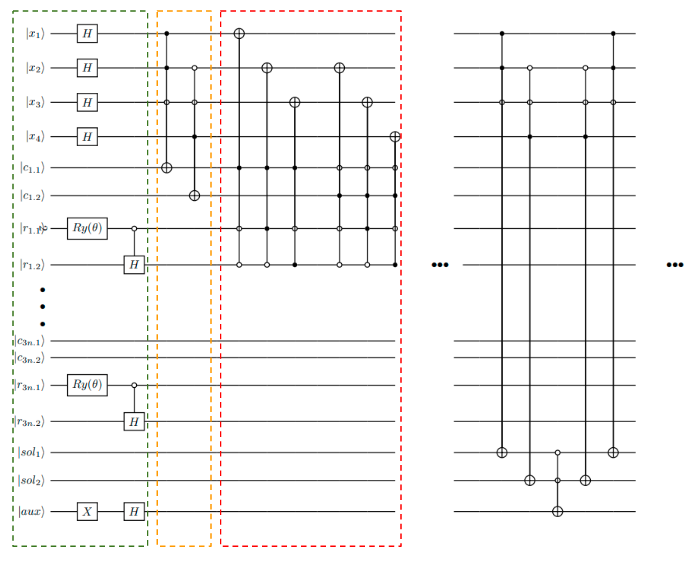

Once we have simulated all the 3n iterations of Schöning's algorithm, we again have to check whether the assignment satisfies the formula. In the affirmative case, we have to perform a phase shift of -1 to mark the assignment as a solution. This step is the same as we have done in Grover's algorithm in the previous notebook. In the following code, we can see the orange step, the red step, and the last checking of the clauses before marking the state if it's a solution (We can see it as another orange step using the last auxiliary qubits). As before, we encapsulate the circuit in a gate called *Schoning* to use it in the next cell to complete the oracle.

In [4]:
qc = QuantumCircuit(n_qubits)

for it in range(iters):
    first_bit = n_var+(2+n_clause)*it+n_clause
    first_clause = n_var+(2+n_clause)*it
    nc = 0
    for clause in formula:
        control = list()

        for lit in clause:
            lit_aux = abs(lit)-1
            if lit < 0:
                qc.x(lit_aux)
            control.append(lit_aux)

        qc.mct(control,first_clause+nc)

        for lit in clause:
            if lit < 0:
                lit_aux = abs(lit)-1
                qc.x(lit_aux)

        nc += 1

    nc = 0
    for clause in formula:
        lit1 = abs(clause[0])-1
        lit2 = abs(clause[1])-1
        lit3 = abs(clause[2])-1
        control = list()
        control.append(first_bit)
        control.append(first_bit+1)
        control.append(first_clause+nc)


        for n in range(nc):
            control.append(first_clause+n)
            qc.x(first_clause+n)

        qc.x(first_bit)
        qc.x(first_bit+1)
        qc.mct(control,lit1)
        qc.x(first_bit+1)
        qc.x(first_bit)

        qc.x(first_bit+1)
        qc.mct(control,lit2)
        qc.x(first_bit+1)

        qc.x(first_bit)
        qc.mct(control,lit3)
        qc.x(first_bit)

        for n in range(nc):
            qc.x(first_clause+n)

        nc += 1


nc = 0
for clause in formula:
    control = list()

    for lit in clause:
        lit_aux = abs(lit)-1
        if lit < 0:
            qc.x(lit_aux)
        control.append(lit_aux)

    qc.mct(control,n_qubits-1-n_clause+nc)

    for lit in clause:
        if lit < 0:
            lit_aux = abs(lit)-1
            qc.x(lit_aux)

    nc += 1

    
schoning_step = qc.to_gate()
schoning_step.name = "Schoning"
qc.draw(fold=10000)

┌───┐     ┌───┐┌───┐     ┌───┐┌───┐     ┌───┐┌───┐                                   ┌───┐                                   ┌───┐                                   ┌───┐                                   ┌───┐                                   ┌───┐                                   ┌───┐                                                                      ┌───┐     ┌───┐┌───┐     ┌───┐┌───┐     ┌───┐┌───┐                                   ┌───┐                                   ┌───┐                                   ┌───┐                                   ┌───┐                                   ┌───┐                                   ┌───┐                                                                      ┌───┐     ┌───┐┌───┐     ┌───┐┌───┐     ┌───┐┌───┐                                   ┌───┐                                   ┌───┐                                   ┌───┐                                   ┌───┐                                   ┌───┐                                   ┌───┐                                                                      ┌───┐     ┌───┐┌───┐     ┌───┐┌───┐     ┌───┐┌───┐                                   ┌───┐                                   ┌───┐                                   ┌───┐                                   ┌───┐                                   ┌───┐                                   ┌───┐                                                                      ┌───┐     ┌───┐┌───┐     ┌───┐┌───┐     ┌───┐┌───┐                                   ┌───┐                                   ┌───┐                                   ┌───┐                                   ┌───┐                                   ┌───┐                                   ┌───┐                                                                      ┌───┐     ┌───┐┌───┐     ┌───┐┌───┐     ┌───┐┌───┐                                   ┌───┐                                   ┌───┐                                   ┌───┐                                   ┌───┐                                   ┌───┐                                   ┌───┐                                                                      ┌───┐     ┌───┐┌───┐     ┌───┐┌───┐     ┌───┐┌───┐                                   ┌───┐                                   ┌───┐                                   ┌───┐                                   ┌───┐                                   ┌───┐                                   ┌───┐                                                                      ┌───┐     ┌───┐┌───┐     ┌───┐┌───┐     ┌───┐┌───┐                                   ┌───┐                                   ┌───┐                                   ┌───┐                                   ┌───┐                                   ┌───┐                                   ┌───┐                                                                      ┌───┐     ┌───┐┌───┐     ┌───┐┌───┐     ┌───┐┌───┐                                   ┌───┐                                   ┌───┐                                   ┌───┐                                   ┌───┐                                   ┌───┐                                   ┌───┐                                                                      ┌───┐     ┌───┐┌───┐     ┌───┐┌───┐     ┌───┐
 q_0: ──■─────────■─────────■──────────────■──┤ X ├──■──┤ X ├┤ X ├──■──┤ X ├┤ X ├──■──┤ X ├┤ X ├───────────────────────────────────┤ X ├───────────────────────────────────┤ X ├───────────────────────────────────┤ X ├───────────────────────────────────┤ X ├───────────────────────────────────┤ X ├───────────────────────────────────┤ X ├────────────────────────────────■─────────■─────────■──────────────■──┤ X ├──■──┤ X ├┤ X ├──■──┤ X ├┤ X ├──■──┤ X ├┤ X ├───────────────────────────────────┤ X ├───────────────────────────────────┤ X ├───────────────────────────────────┤ X ├───────────────────────────────────┤ X ├───────────────────────────────────┤ X ├───────────────────────────────────┤ X ├──────────────────

In the next cell, we can finish our oracle. The oracle code is divided into two cells because, thanks to the gate with the circuit above, we can quickly generate its complex conjugate transpose with the Qiskit function *inverse*. We need to do so to revert all the computations before going to the next step of the Amplitude Amplification.

Between the gate called *Schoning* and its inverse, we need to use a Toffoli gate to negate the last qubit performing a phase shift of -1 and mark the solution states. In that Toffoli gate, we will use the negation of the auxiliary qubits modified in the last step in the previous cell because when they are |0⟩, it means the clause is satisfied.

These three steps are encapsulated in another gated called *Oracle* which we will use in the Amplitude Amplification at the end.

In [5]:
qc = QuantumCircuit(n_qubits)

qc.append(schoning_step, list(range(n_qubits)))

control = list()
for nc in range(n_clause):
    qc.x(n_qubits-1-n_clause+nc)
    control.append(n_qubits-1-n_clause+nc)

qc.mct(control,n_qubits-1)

for nc in range(n_clause):
    qc.x(n_qubits-1-n_clause+nc)

qc.append(schoning_step.inverse(), list(range(n_qubits)))

oracle = qc.to_gate()
oracle.name = "Oracle"
qc.draw()

┌────────────┐               ┌───────────────┐
 q_0: ┤0           ├───────────────┤0              ├
      │            │               │               │
 q_1: ┤1           ├───────────────┤1              ├
      │            │               │               │
 q_2: ┤2           ├───────────────┤2              ├
      │            │               │               │
 q_3: ┤3           ├───────────────┤3              ├
      │            │               │               │
 q_4: ┤4           ├───────────────┤4              ├
      │            │               │               │
 q_5: ┤5           ├───────────────┤5              ├
      │            │               │               │
 q_6: ┤6           ├───────────────┤6              ├
      │            │               │               │
 q_7: ┤7           ├───────────────┤7              ├
      │            │               │               │
 q_8: ┤8           ├───────────────┤8              ├
      │            │               │               │
 q_9: ┤9           ├───────────────┤9              ├
      │            │               │               │
q_10: ┤10          ├───────────────┤10             ├
      │            │               │               │
q_11: ┤11          ├───────────────┤11             ├
      │            │               │               │
q_12: ┤12          ├───────────────┤12             ├
      │            │               │               │
q_13: ┤13          ├───────────────┤13             ├
      │            │               │               │
q_14: ┤14          ├───────────────┤14             ├
      │            │               │               │
q_15: ┤15          ├───────────────┤15             ├
      │            │               │               │
q_16: ┤16          ├───────────────┤16             ├
      │            │               │               │
q_17: ┤17          ├───────────────┤17             ├
      │            │               │               │
q_18: ┤18          ├───────────────┤18             ├
      │            │               │               │
q_19: ┤19          ├───────────────┤19             ├
      │            │               │               │
q_20: ┤20          ├───────────────┤20             ├
      │            │               │               │
q_21: ┤21          ├───────────────┤21             ├
      │            │               │               │
q_22: ┤22          ├───────────────┤22             ├
      │            │               │               │
q_23: ┤23          ├───────────────┤23             ├
      │            │               │               │
q_24: ┤24          ├───────────────┤24             ├
      │            │               │               │
q_25: ┤25          ├───────────────┤25             ├
      │            │               │               │
q_26: ┤26          ├───────────────┤26             ├
      │            │               │               │
q_27: ┤27          ├───────────────┤27             ├
      │            │               │               │
q_28: ┤28          ├───────────────┤28             ├
      │            │               │               │
q_29: ┤29          ├───────────────┤29             ├
      │            │               │               │
q_30: ┤30          ├───────────────┤30             ├
      │            │               │               │
q_31: ┤31          ├───────────────┤31             ├
      │            │               │               │
q_32: ┤32          ├───────────────┤32             ├
      │            │               │               │
q_33: ┤33          ├───────────────┤33             ├
      │            │               │               │
q_34: ┤34          ├───────────────┤34             ├
      │            │               │               │
q_35: ┤35          ├───────────────┤35             ├
      │            │               │               │
q_36: ┤36          ├───────────────┤36             ├
      │            │               │               │
q_37: ┤37          ├───────────

The next step is to define the generalized version of what we called in the previous notebook as steps 3, 4, and 5 of Grover's algorithm (inversion about the mean).

We used the Dirac notation to defined the step as $D = H^{⊗n}$ ($2|0⟩⟨0|^{⊗n} - I$) $H^{⊗n}$ = $2|\psi⟩⟨\psi| - I$.

In this case, we cannot use the same definition because it's not true anymore. It is not true that $H^{⊗n} |0⟩^{⊗n} =|\psi⟩$ because $|\psi⟩$ represents our initial state before running the oracle, and in our initialization, we use more gates than only Hadamard. Recall: We have created the state $1\over{\sqrt{3}}$ $(|00⟩ + |01⟩ + |10⟩)$.

A generalization of D, in Dirac notation, could be $D = A$ ($2|0⟩⟨0|^{⊗n} - I$) $A^†$ = $2|\psi⟩⟨\psi| - I$, where $A |0⟩^{⊗n} = |\psi⟩$.

Following this, it's clear that we have to apply the initial transformation where the transformation $A$ appears in the generalization. We also can see that we will use its complex conjugate transpose in place of $A^†$. 

To simplify the circuit, we will use the opposite of step 4, which is to perform a phase shift of -1 to the state $|0⟩^{⊗n}$. This simplification is equivalent because we are applying a global phase.


There is a change between the theoretical circuit and the following implementation to be able to run this circuit in a classical computer. The only Toffoli gate needed in step 4 has been divided into little Toffoli gates using the previous auxiliary qubits used in the oracle to palliate the exponential growth in the simulation. This change is not necessary for the theoretical circuit, but it is to use and speed up the time needed by the simulator presented in the following cells. It's important to know that the formula that we use has to obey certain restrictions:

* $\sum_{i=1}^{\lceil log_4(7n+1) \rceil} {7n+1\over{4^i}} \le c \cdot (3n + 1) $
* $n + 3n \cdot(2 + c) + c + 1 \le 100$

The first restriction appears to make sure that we have enough auxiliary qubits. The base of the logarithm used in the summation comes from the number of control qubits in each Toffoli gate, but if we look closely at the restriction, we can see that it's a tautology, and therefore we don't have to be concerned about it.

The second restriction comes from the limit in the number of qubits the simulator used in this notebook can handle.

In [6]:
qc = QuantumCircuit(n_qubits)

l = list()
aux = list()

ini = n_var
for i in range(iters):
    for j in range(n_clause):
        aux.append(ini+j)
    ini += n_clause+2

for j in range(n_clause):
        aux.append(ini+j)


for i in range(n_var):
    qc.h(i)
    qc.x(i)
    l.append(i)

ini = n_var+n_clause
theta = 2*math.acos(math.sqrt(2/3))
for i in range(iters):
    qc.x(ini)
    qc.ch(ini, ini+1)
    qc.x(ini)
    qc.u(-theta,0,0,ini)

    qc.x(ini)
    qc.x(ini+1)
    l.append(ini)
    l.append(ini+1)
    ini += 2+n_clause

#qc.mct(l,n_qubits-1)
original = l
total = len(l)
l2 = list()
i = 0
while total != 1:
    for j in range(math.ceil(total/4)):
        qc.mct(l[4*j:4*j+4],aux[i])
        l2.append(aux[i])
        i+=1

    l = l2
    total = len(l)
    l2 = list()

diff_part1 = qc.to_gate()
diff_part1.name = "diff_part1"
qc.draw()

┌───┐┌───┐                                                              »
 q_0: ┤ H ├┤ X ├──────────────────────────────────■───────────────────────────»
      ├───┤├───┤                                  │                           »
 q_1: ┤ H ├┤ X ├──────────────────────────────────■───────────────────────────»
      ├───┤├───┤                                  │                           »
 q_2: ┤ H ├┤ X ├──────────────────────────────────■───────────────────────────»
      └───┘└───┘                                ┌─┴─┐                         »
 q_3: ──────────────────────────────────────────┤ X ├──────────────────────■──»
                                                └─┬─┘┌───┐                 │  »
 q_4: ────────────────────────────────────────────┼──┤ X ├─────────────────■──»
                                                  │  └─┬─┘┌───┐            │  »
 q_5: ────────────────────────────────────────────┼────┼──┤ X ├────────────■──»
                                                  │    │  └─┬─┘┌───┐       │  »
 q_6: ────────────────────────────────────────────┼────┼────┼──┤ X ├───────■──»
                                                  │    │    │  └─┬─┘┌───┐  │  »
 q_7: ────────────────────────────────────────────┼────┼────┼────┼──┤ X ├──┼──»
                                      ┌───┐       │    │    │    │  └─┬─┘  │  »
 q_8: ────────────────────────────────┤ X ├───────┼────┼────┼────┼────┼────┼──»
                                      └─┬─┘       │    │    │    │    │  ┌─┴─┐»
 q_9: ──────────────────────────────────┼─────────┼────┼────┼────┼────┼──┤ X ├»
      ┌───┐     ┌───┐┌───────────────┐  │  ┌───┐  │    │    │    │    │  └───┘»
q_10: ┤ X ├──■──┤ X ├┤ U(-1.231,0,0) ├──┼──┤ X ├──■────┼────┼────┼────┼───────»
      └───┘┌─┴─┐├───┤└───────────────┘  │  └───┘       │    │    │    │       »
q_11: ─────┤ H ├┤ X ├───────────────────┼──────────────■────┼────┼────┼───────»
           └───┘└───┘                   │              │    │    │    │       »
q_12: ──────────────────────────────────┼──────────────┼────┼────┼────┼───────»
                                        │              │    │    │    │       »
q_13: ──────────────────────────────────┼──────────────┼────┼────┼────┼───────»
                                        │              │    │    │    │       »
q_14: ──────────────────────────────────┼──────────────┼────┼────┼────┼───────»
                                        │              │    │    │    │       »
q_15: ──────────────────────────────────┼──────────────┼────┼────┼────┼───────»
                                        │              │    │    │    │       »
q_16: ──────────────────────────────────┼──────────────┼────┼────┼────┼───────»
                                        │              │    │    │    │       »
q_17: ──────────────────────────────────┼──────────────┼────┼────┼────┼───────»
                                        │              │    │    │    │       »
q_18: ──────────────────────────────────┼──────────────┼────┼────┼────┼───────»
      ┌───┐     ┌───┐┌───────────────┐  │  ┌───┐       │    │    │    │       »
q_19: ┤ X ├──■──┤ X ├┤ U(-1.231,0,0) ├──┼──┤ X ├───────■────┼────┼────┼───────»
      └───┘┌─┴─┐├───┤└───────────────┘  │  └───┘       │    │    │    │       »
q_20: ─────┤ H ├┤ X ├───────────────────┼──────────────■────┼────┼────┼───────»
           └───┘└───┘                   │              │    │    │    │       »
q_21: ──────────────────────────────────┼──────────────┼────┼────┼────┼───────»
                                        │              │    │    │    │       »
q_22: ──────────────────────────────────┼──────────────┼────┼────┼────┼───────»
                                        │              │    │    │    │       »
q_23: ──────────────────────────────────┼──────────────┼────┼────┼────┼───────»
                                        │              │    │    │    │       »
q_24: ──────────────────────────────────┼──────────────┼────┼────┼────┼───────»
      

To finish with the generalization of the steps 3, 4, and 5 of Grover's algorithm or inversion about the mean, we need to use the above code encapsulated into a gate called *diff_part1*, negate the last qubit to perform the phase shift of step 4 and finally, use the gate *diff_part1* dagger (complex conjugate transpose) to reverse all the changes in the auxiliary qubits.

In the next cell, we can see the code:

In [7]:
qc = QuantumCircuit(n_qubits)

qc.append(diff_part1, list(range(n_qubits)))

qc.mct(l,n_qubits-1)

qc.append(diff_part1.inverse(), list(range(n_qubits)))

diffuser = qc.to_gate()
diffuser.name = "Diffuser"
qc.draw()

┌──────────────┐     ┌─────────────────┐
 q_0: ┤0             ├─────┤0                ├
      │              │     │                 │
 q_1: ┤1             ├─────┤1                ├
      │              │     │                 │
 q_2: ┤2             ├─────┤2                ├
      │              │     │                 │
 q_3: ┤3             ├─────┤3                ├
      │              │     │                 │
 q_4: ┤4             ├─────┤4                ├
      │              │     │                 │
 q_5: ┤5             ├─────┤5                ├
      │              │     │                 │
 q_6: ┤6             ├─────┤6                ├
      │              │     │                 │
 q_7: ┤7             ├─────┤7                ├
      │              │     │                 │
 q_8: ┤8             ├─────┤8                ├
      │              │     │                 │
 q_9: ┤9             ├─────┤9                ├
      │              │     │                 │
q_10: ┤10            ├─────┤10               ├
      │              │     │                 │
q_11: ┤11            ├─────┤11               ├
      │              │     │                 │
q_12: ┤12            ├─────┤12               ├
      │              │     │                 │
q_13: ┤13            ├──■──┤13               ├
      │              │  │  │                 │
q_14: ┤14            ├──┼──┤14               ├
      │              │  │  │                 │
q_15: ┤15            ├──┼──┤15               ├
      │              │  │  │                 │
q_16: ┤16            ├──┼──┤16               ├
      │              │  │  │                 │
q_17: ┤17            ├──┼──┤17               ├
      │              │  │  │                 │
q_18: ┤18            ├──┼──┤18               ├
      │              │  │  │                 │
q_19: ┤19            ├──┼──┤19               ├
      │              │  │  │                 │
q_20: ┤20            ├──┼──┤20               ├
      │              │  │  │                 │
q_21: ┤21            ├──┼──┤21               ├
      │              │  │  │                 │
q_22: ┤22            ├──┼──┤22               ├
      │              │  │  │                 │
q_23: ┤23            ├──┼──┤23               ├
      │              │  │  │                 │
q_24: ┤24            ├──┼──┤24               ├
      │              │  │  │                 │
q_25: ┤25            ├──┼──┤25               ├
      │              │  │  │                 │
q_26: ┤26            ├──┼──┤26               ├
      │              │  │  │                 │
q_27: ┤27            ├──┼──┤27               ├
      │              │  │  │                 │
q_28: ┤28            ├──┼──┤28               ├
      │              │  │  │                 │
q_29: ┤29            ├──┼──┤29               ├
      │              │  │  │                 │
q_30: ┤30            ├──┼──┤30               ├
      │              │  │  │                 │
q_31: ┤31            ├──┼──┤31               ├
      │              │  │  │                 │
q_32: ┤32            ├──┼──┤32               ├
      │              │  │  │                 │
q_33: ┤33            ├──┼──┤33               ├
      │              │  │  │                 │
q_34: ┤34            ├──┼──┤34               ├
      │              │  │  │                 │
q_35: ┤35            ├──┼──┤35               ├
      │              │  │  │                 │
q_36: ┤36            ├──┼──┤36               ├
      │              │  │  │                 │
q_37: ┤37            ├──┼──┤37               ├
      │              │  │  │                 │
q_38: ┤38            ├──┼──┤38               ├
      │              │  │  │                 │
q_39: ┤39            ├──┼──┤39               ├
      │              │  │  │                 │
q_40: ┤40            ├──┼──┤40               ├
      │              │  │  │                 │
q_41: ┤41            ├──┼──┤41               ├
      │              │  │  │                 │
q_42: ┤42  

At this point, we have all the ingredients to run the Amplitude Amplification simulating Schöning's algorithm as the oracle. As in the previous notebook, we can calculate an upper bound of the number of repetitions of our generalized Grover's operator as follows:

$R \le \lceil {{\pi}\over{4}} \cdot \sqrt{({4\over3})^n}  \rceil$

In [8]:
rounds = math.pi/4.0*math.sqrt((4/3)**n_var)
print("Result:",rounds)
print("Iterations R ≤",math.ceil(rounds))

if math.floor(rounds) == 0:
    rounds = round(rounds)
else:
    rounds = math.floor(rounds)

print("Iterations chosen:", rounds)

Result: 1.2091995761561452
Iterations R ≤ 2
Iterations chosen: 1


Finally, we can build the Amplitude Amplification's circuit:

In [9]:
qc = QuantumCircuit(n_qubits,n_measures)

qc.append(initial, list(range(n_qubits)))
for i in range(rounds):
    qc.append(oracle, list(range(n_qubits)))
    qc.append(diffuser, list(range(n_qubits)))

actual = 0

for i in range(n_var):
    qc.measure([i],[i])
    actual += 1

ini = n_var+n_clause
for i in range(iters):
    qc.measure([ini],[actual])
    qc.measure([ini+1],[actual+1])
    ini += 2+n_clause
    actual += 2

qc.draw()

┌──────────────────┐┌──────────┐┌────────────┐┌─┐                        »
 q_0: ┤0                 ├┤0         ├┤0           ├┤M├────────────────────────»
      │                  ││          ││            │└╥┘┌─┐                     »
 q_1: ┤1                 ├┤1         ├┤1           ├─╫─┤M├─────────────────────»
      │                  ││          ││            │ ║ └╥┘┌─┐                  »
 q_2: ┤2                 ├┤2         ├┤2           ├─╫──╫─┤M├──────────────────»
      │                  ││          ││            │ ║  ║ └╥┘                  »
 q_3: ┤3                 ├┤3         ├┤3           ├─╫──╫──╫───────────────────»
      │                  ││          ││            │ ║  ║  ║                   »
 q_4: ┤4                 ├┤4         ├┤4           ├─╫──╫──╫───────────────────»
      │                  ││          ││            │ ║  ║  ║                   »
 q_5: ┤5                 ├┤5         ├┤5           ├─╫──╫──╫───────────────────»
      │                  ││          ││            │ ║  ║  ║                   »
 q_6: ┤6                 ├┤6         ├┤6           ├─╫──╫──╫───────────────────»
      │                  ││          ││            │ ║  ║  ║                   »
 q_7: ┤7                 ├┤7         ├┤7           ├─╫──╫──╫───────────────────»
      │                  ││          ││            │ ║  ║  ║                   »
 q_8: ┤8                 ├┤8         ├┤8           ├─╫──╫──╫───────────────────»
      │                  ││          ││            │ ║  ║  ║                   »
 q_9: ┤9                 ├┤9         ├┤9           ├─╫──╫──╫───────────────────»
      │                  ││          ││            │ ║  ║  ║ ┌─┐               »
q_10: ┤10                ├┤10        ├┤10          ├─╫──╫──╫─┤M├───────────────»
      │                  ││          ││            │ ║  ║  ║ └╥┘┌─┐            »
q_11: ┤11                ├┤11        ├┤11          ├─╫──╫──╫──╫─┤M├────────────»
      │                  ││          ││            │ ║  ║  ║  ║ └╥┘            »
q_12: ┤12                ├┤12        ├┤12          ├─╫──╫──╫──╫──╫─────────────»
      │                  ││          ││            │ ║  ║  ║  ║  ║             »
q_13: ┤13                ├┤13        ├┤13          ├─╫──╫──╫──╫──╫─────────────»
      │                  ││          ││            │ ║  ║  ║  ║  ║             »
q_14: ┤14                ├┤14        ├┤14          ├─╫──╫──╫──╫──╫─────────────»
      │                  ││          ││            │ ║  ║  ║  ║  ║             »
q_15: ┤15                ├┤15        ├┤15          ├─╫──╫──╫──╫──╫─────────────»
      │                  ││          ││            │ ║  ║  ║  ║  ║             »
q_16: ┤16                ├┤16        ├┤16          ├─╫──╫──╫──╫──╫─────────────»
      │                  ││          ││            │ ║  ║  ║  ║  ║             »
q_17: ┤17                ├┤17        ├┤17          ├─╫──╫──╫──╫──╫─────────────»
      │                  ││          ││            │ ║  ║  ║  ║  ║             »
q_18: ┤18                ├┤18        ├┤18          ├─╫──╫──╫──╫──╫─────────────»
      │                  ││          ││            │ ║  ║  ║  ║  ║ ┌─┐         »
q_19: ┤19                ├┤19        ├┤19          ├─╫──╫──╫──╫──╫─┤M├─────────»
      │                  ││          ││            │ ║  ║  ║  ║  ║ └╥┘┌─┐      »
q_20: ┤20                ├┤20        ├┤20          ├─╫──╫──╫──╫──╫──╫─┤M├──────»
      │                  ││          ││            │ ║  ║  ║  ║  ║  ║ └╥┘      »
q_21: ┤21                ├┤21        ├┤21          ├─╫──╫──╫──╫──╫──╫──╫───────»
      │                  ││          ││            │ ║  ║  ║  ║  ║  ║  ║       »
q_22: ┤22                ├┤22        ├┤22          ├─╫──╫──╫──╫──╫──╫──╫───────»
      │                  ││          ││            │ ║  ║  ║  ║  ║  ║  ║       »
q_23: ┤23                ├┤23        ├┤23          ├─╫──╫──╫──╫──╫──╫──╫───────»
      │                  ││          ││            │ ║  ║  ║  ║  ║  ║  ║       »
q_24: ┤24                ├┤24        

In the next cell, we can see the code to simulate the circuit and get the results. Qiskit has different kinds of simulators, and in this notebook, we will use the *matrix_product_state*, which allows us to run circuits up to 100 qubits. 

We can find further details about the simulator at this link: https://qiskit.org/documentation/tutorials/simulators/7_matrix_product_state_method.html?highlight=matrix%20product

To see all the simulators available: https://quantum-computing.ibm.com/lab/docs/iql/manage/simulator/

In [10]:
# Select the AerSimulator from the Aer provider
simulator = AerSimulator(method='matrix_product_state')
#simulator = AerSimulator(method='statevector')
#simulator = AerSimulator(method='extended_stabilizer')

# Run and get counts, using the matrix_product_state method
tcirc = transpile(qc, simulator)
result = simulator.run(tcirc, shots=1).result()
print('This succeeded?: {}'.format(result.success))
counts = result.get_counts(0)
print(counts)

This succeeded?: True
{'100101001000100000011': 1}


The Amplitude Amplification returns us an initial assignment for Schöning’s algorithm and, in binary, the 3n variable positions that we will flip in the leftmost false clause.

In [11]:
assig = list(next(iter(counts))[::-1][0:n_var])
steps = next(iter(counts))[::-1][n_var:]

print(assig)
print(steps)

['1', '1', '0']
000001000100101001


In the next cell, we can find two functions where the first one returns True if a given assignment satisfies a given formula and False otherwise, and the second function is the implementation of Schöning's algorithm when we know beforehand which literal we will flip (as a string of 3n positions in binary) and the initial assignment. As we can see, we will use the first function to determine if the formula is satisfied in each iteration of the second one.

In [12]:
def check_formula(formula, assig):
    c = 0
    for clause in formula:
        lit1_pos = abs(clause[0])-1
        lit2_pos = abs(clause[1])-1
        lit3_pos = abs(clause[2])-1
        total = 0
        
        if (clause[0] < 0 and assig[lit1_pos] == '0') or (clause[0] > 0 and assig[lit1_pos] == '1'):
            total += 1
            
        if (clause[1] < 0 and assig[lit2_pos] == '0') or (clause[1] > 0 and assig[lit2_pos] == '1'):
            total += 1
        
        if (clause[2] < 0 and assig[lit3_pos] == '0') or (clause[2] > 0 and assig[lit3_pos] == '1'):
            total += 1
            
        if total == 0:
            return (False,c)
        
        c += 1
    
    return (True,-1)

def schoning(formula,assig,steps,verbose=True):
    
    n = len(assig)
    
    if verbose:
            print("initial guess","->",assig)
            print("")

    for i in range(3*n):
        checking = check_formula(formula, assig)
        if checking[0]:
            return True
        
        lit = int(steps[2*i])+2*int(steps[2*i+1])
        var = abs(formula[checking[1]][lit])-1
        
        if assig[var] == '0':
            assig[var] = '1'
        else:
            assig[var] = '0'
        
        if verbose:
            print("iter",i+1,"->",assig)
            
    return check_formula(formula, assig)[0]

Here we have an execution of Schöning's algorithm with the result obtained in the Amplitude Amplification. Each iteration of Schöning's has been printed to see all the flips and the path toward the solution.

In [13]:
schoning(formula,assig,steps)

initial guess -> ['1', '1', '0']

iter 1 -> ['0', '1', '0']
iter 2 -> ['1', '1', '0']
iter 3 -> ['1', '1', '1']


True

Additionally, we can see how often our algorithm returns a false assignment modifying the parameter called *shots* in the third line to run the circuit the times we want.

In [14]:
simulator = AerSimulator(method='matrix_product_state')
tcirc = transpile(qc, simulator)
result = simulator.run(tcirc, shots=1024).result()
print('This succeeded?: {}'.format(result.success))
counts = result.get_counts(0)

This succeeded?: True


Finally, we can calculate the percentage of satisfied assignments found by the Amplitude Amplification. That percentage could be better if we get closer to the exact number of repetitions seen above without surpassing it. In this case, we cannot do so because we can only do an integer number of repetitions.

In [15]:
total = 0
true = 0
for key in counts:
    assig = list(key[::-1][0:n_var])
    steps = key[::-1][n_var:]
    r = schoning(formula,assig,steps,verbose=False)
    if r:
        true += counts[key]
    total += counts[key]
print(true/total*100,"% of success")

93.359375 % of success


Notice that in this circuit, we don't use an extra qubit to create an augmented space as in the previous notebook because the example that has been used represents the worst-case scenario in which our formula has only one solution, and therefore, we don't need that extra qubit.

We calculate the number of repetitions using the probability of success in one run of the Schöning classical algorithm. This probability, again, is in the worst-case, so in formulas with more than one solution, that probability should increase, and the number of repetitions should be lower.